# Destination Predictor for Airbnb 


Aim of the project is to build a predictive system for Airbnb. That helps Airbnb to fortell the new users first travel destination i.e. predict in which country a new user will make his or her first booking. On basis of that Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.


Data Set is from Kaggle. 
Link : https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings








## Questions 


> Can gender of the user determine the first travel destination of the AirBnb user? <br /><br />
> Does a certain age group prefer to visit any particular country? <br /><br />
> What is the trend for folks, who don't & do book space through AirBnb in relation with time? <br />  
>> How popular is AirBnB? * 

## Task
> To predict the first travel destination of the AirBnb user. <br />

In [2]:
import os
import warnings


import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import missingno as msno

import regex as re

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn import svm

from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import (LabelEncoder, OneHotEncoder)

from statistics import mean 


from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer



import xgboost as xgb




%matplotlib inline

__WARNING __ 

The determination whether to issue a warning message is controlled by the warning filter, which is a sequence of matching rules and actions. Rules can be added to the filter by calling ___filterwarnings()___. 

In [3]:
warnings.filterwarnings('ignore')


__List the files in the dataset__ 

- ___chdir___  : Changes the directory to the file that has to be acced
- ___listdir___  : Lists down the names of the files in the directory, related to project. 

In [4]:
os.chdir(r"C:\Users\Shradhit\DataScience_Project_DataSet")
os.getcwd()


'C:\\Users\\Shradhit\\DataScience_Project_DataSet'

In [5]:
os.listdir(r"C:\Users\Shradhit\DataScience_Project_DataSet")


['.ipynb_checkpoints',
 'age_gender_bkts.csv',
 'all.zip',
 'countries.csv',
 'notebook_env.db',
 'sample_submission_NDF.csv',
 'session.pkl',
 'sessions.csv',
 'test_users.csv',
 'train_users_2.csv']

## First View of the Data 


### countries.csv

Checking the datatype of the columns in the .csv file - __countries.csv__. 

_info_ prints out a concise summary of a DataFrame. This method prints information about a DataFrame including the index data type and column data types, non-null values and memory usage.

In [6]:
country_info =  pd.read_csv('countries.csv')
country_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 640.0+ bytes


In [7]:
country_info.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


### age_gender_bkts.csv


Summarizing the data inside the file __age_gender_bkts.csv__

        

In [8]:
agb = pd.read_csv('age_gender_bkts.csv')
agb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


__Splitting the age_bucket to simpler format i.e. min_age and max_age. Thus appending the same to the dataframe. __

In [9]:
t = list(agb['age_bucket'])
min_age = []
max_age = []
for x in t:
    if(re.match("([0-9]+\-[0-9]+)", x)):
        min_age.append(re.split("\-|[+]", x)[0]) 
        max_age.append(re.split("\-|[+]", x)[1])
    else: 
        min_age.append(re.split("\-|[+]", x)[0])
        max_age.append(np.NAN)

agb['min_age'] = min_age
agb['max_age'] = max_age


In [10]:
agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year,min_age,max_age
0,100+,AU,male,1.0,2015.0,100,NaN
1,95-99,AU,male,9.0,2015.0,95,99
2,90-94,AU,male,47.0,2015.0,90,94
3,85-89,AU,male,118.0,2015.0,85,89
4,80-84,AU,male,199.0,2015.0,80,84


## train_user_2.csv
Summarizing the data inside the file train_users_2.csv

In [11]:
df_users = pd.read_csv('train_users_2.csv')


In [12]:
df_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [13]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [14]:
df_users.columns.tolist()


['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

__The density of the column is presented using the graph. __

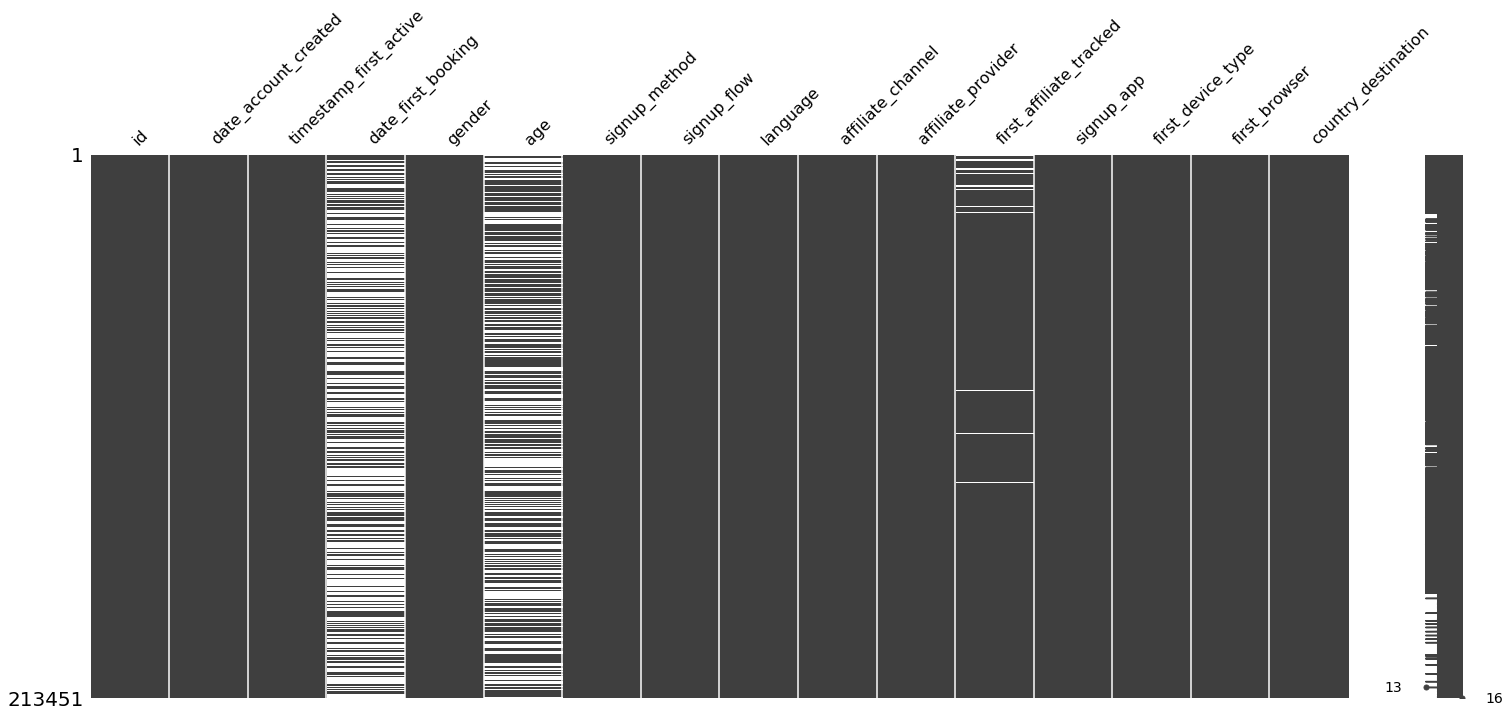

In [15]:
msno.matrix(df_users)



## Data Visualization & Insights 

## Age 

Viewing the age distribution in the dataset and converting all the ages above 100 to NA.

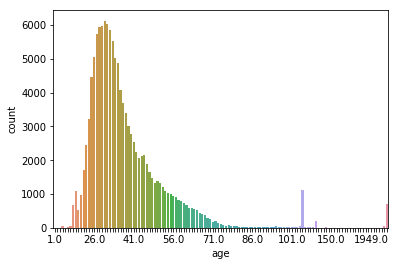

In [16]:
df_users['age'] = df_users['age'].dropna()
ax = sns.countplot(df_users['age'])
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 15 == 0:  # every 15th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [17]:
df_users.loc[df_users['age'] > 100, 'age'] = np.NaN


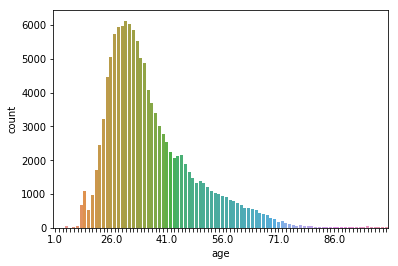

In [18]:
df_users['age'] = df_users['age'].dropna()
ax = sns.countplot(df_users['age'])
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 15 == 0:  # every 15th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

Are some age groups more likely to book in a particular destination? </br>
To answer this question, we will use the box plot and look at the distribution of ages for travellers to a particular country.

__Does a certain age group prefer to visit any perticular country?__

(10, 75)

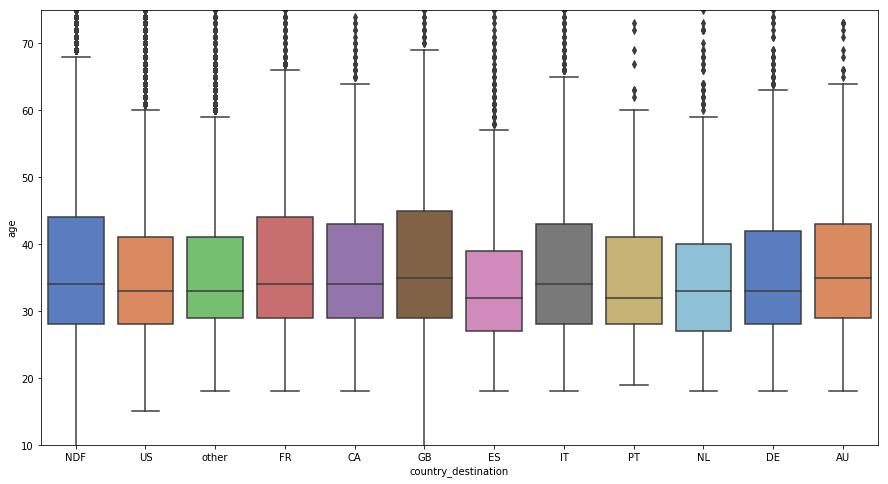

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (15, 8))
sns.boxplot(x = 'country_destination', y = 'age', data = df_users, palette="muted", ax = ax)
ax.set_ylim([10, 75])

We find that the distribution is more or less the same for every country. <br />
*Great Britain (GB)* has the highest median age of travellers and *Spain(ES)* is more popular amongst younger travellers. 

### Gender 

Looking at the gender distribution and marking the **-unknown-** as **NA**.

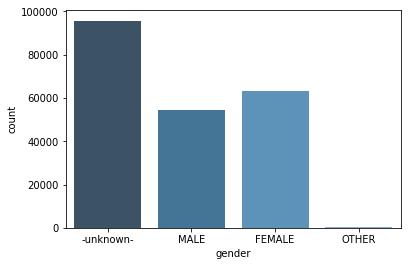

In [20]:
sns.countplot(df_users['gender'], palette = "Blues_d")


In [21]:
df_users['gender'] = df_users['gender'].replace('-unknown-', np.nan)

#df_users.loc[df_users['gender'] == '-unknown-', 'gender'] = np.NaN


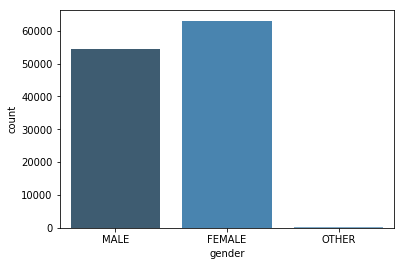

In [22]:
sns.countplot(df_users['gender'], palette = "Blues_d")


### Trend Check - Gender

__Checking for trend in country destinations in users who put -unknown- (NAN) in relation to the set (MALE, FEMALE & OTHER) ?__


In [23]:

#total number who have NaN genders, and their destinations (proportional)
na_genders = df_users.loc[df_users['gender'].isna(), 'country_destination'].value_counts().sum()
na_gender_countries = df_users.loc[df_users['gender'].isna(), 'country_destination'].value_counts() / na_genders * 100

#non NaN country destinations (proportional)
complete_genders = df_users.loc[df_users['gender'].notnull(), 'country_destination'].value_counts().sum()
complete_gender_countries = df_users.loc[df_users['gender'].notnull(), 'country_destination'].value_counts() / complete_genders * 100

compared_na_genders = pd.concat([na_gender_countries, complete_gender_countries], axis = 1)
compared_na_genders.columns = ['na gender countries', 'complete gender countries']
compared_na_genders



,na gender countries,complete gender countries
NDF,69.674358,49.143619
US,21.015174,35.891579
other,3.625324,5.625706
FR,1.790193,2.810730
IT,1.086866,1.524248
GB,0.792158,1.329789
ES,0.747220,1.302616
CA,0.513126,0.795666
DE,0.296798,0.659800
NL,0.237229,0.454302


__Majority folks with NaN as their gender don't book AirBnB.__

In [24]:
#find number of female, male & other users


female = df_users.loc[df_users['gender'] == 'FEMALE', 'country_destination'].value_counts().sum()
male = df_users.loc[df_users['gender'] == 'MALE', 'country_destination'].value_counts().sum()
other = df_users.loc[df_users['gender'] == 'OTHER', 'country_destination'].value_counts().sum()

#scale according to total numbers of female, male & other users

female_destinations = df_users.loc[df_users['gender'] == 'FEMALE', 'country_destination'].value_counts() / female * 100
male_destinations = df_users.loc[df_users['gender'] == 'MALE', 'country_destination'].value_counts() / male * 100
other_destination = df_users.loc[df_users['gender'] == 'OTHER', 'country_destination'].value_counts() / other * 100


gender_dest = pd.concat([female_destinations, male_destinations, other_destination], axis=1, sort=True)
gender_dest.columns = ['female destinations', 'male destinations', 'other_destination']
gender_dest

,female destinations,male destinations,other_destination
AU,0.328358,0.345334,0.354610
CA,0.721753,0.876194,1.773050
DE,0.567884,0.764144,1.063830
ES,1.353088,1.243571,1.418440
FR,3.112260,2.452241,4.609929
GB,1.397503,1.252755,1.063830
IT,1.730620,1.283982,1.773050
NDF,49.250488,49.079721,37.588652
NL,0.402912,0.510654,1.063830
PT,0.123729,0.126745,0.354610


We see that males, females and others present similar characteristics. Tho we see folks who have marked themselves as other do consider coming to America as their first destination more than the folks under Male and Female catagory.      

### How popular is AirBnB? ( Affiliate Channels )

In [27]:
df_users.affiliate_provider.value_counts()


direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
yahoo                     496
gsp                       453
meetup                    347
email-marketing           166
naver                      52
baidu                      29
yandex                     17
wayn                        8
daum                        1
Name: affiliate_provider, dtype: int64

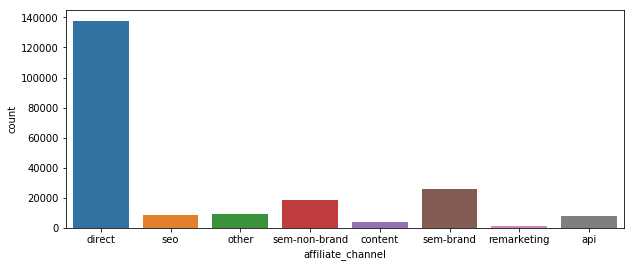

In [28]:
plt.figure(figsize=(10,4))
sns.countplot(df_users['affiliate_channel'])

### Count - Target values 

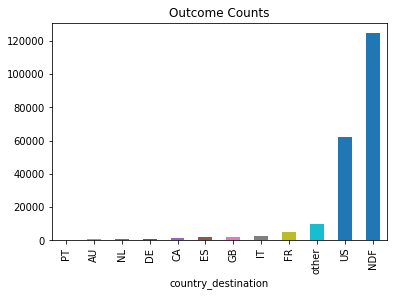

In [29]:
dest = df_users.groupby(df_users["country_destination"])['id'].count().sort_values()
dest.plot(kind='bar')
plt.title("Outcome Counts")
#plt.savefig("outcomecoountry")
plt.show()


### Dates

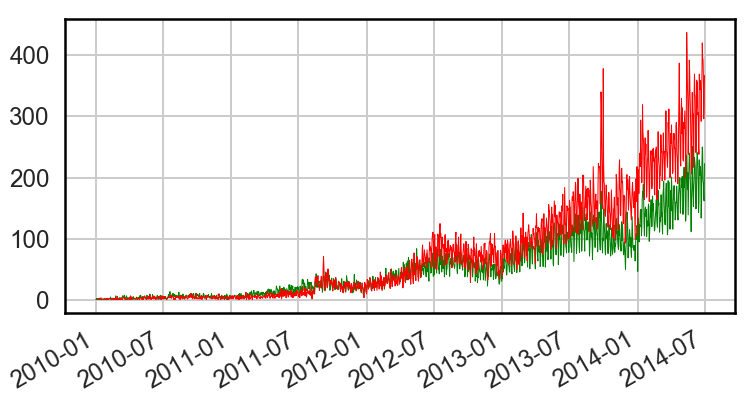

In [30]:
df_users['date_account_created'] = pd.to_datetime(df_users['date_account_created'])
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
plt.figure(figsize=(12,6))

df_users[df_users['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='green')
df_users[df_users['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='red')

The number of non booking users have increased more than the number of booking users as time passed by. This can be attributed to the fact that more people are using the platform just for exploration. 


## Dummy Classifier - Baseline Classifier

Dummy classifier does not reqire the pre-processing of the data.


Two types of dummy classifiers those were used included, 

- **stratified**: generates predictions by respecting the training set’s class distribution.
- **uniform**: generates predictions uniformly at random.

In [31]:
def judge_model(model, name, plot=False):
    print(name)
    print('-'*20)
    
    print('Training Performance')
    print('-> Accuracy :', accuracy_score(y_train, model.predict(x_train)))
    print('-> Precision :', precision_score(y_train, model.predict(x_train),  average='macro'))
    print('-> Recall :', recall_score(y_train, model.predict(x_train),  average='macro'))
    
    
    print('Testing Performance')
    print('-> Accuracy:', accuracy_score(y_test, model.predict(x_test)) )
    print('-> Precision:', precision_score(y_test, model.predict(x_test),  average='macro') )
    print('-> Recall:', recall_score(y_test, model.predict(x_test),  average='macro') )
    

    
    
    

In [32]:
labels = df_users['country_destination'].values
x_train,x_test,y_train,y_test = train_test_split(df_users,labels,test_size=0.25,random_state=1)

In [33]:
for strategy in ['stratified', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(x_train, y_train)
    judge_model(dummy, 'Dummy {}'.format(strategy), plot=True)
    

Dummy stratified
--------------------
Training Performance
-> Accuracy : 0.4298885612912898
-> Precision : 0.08355554052216185
-> Recall : 0.08282906838295864
Testing Performance
-> Accuracy: 0.4335963120514214
-> Precision: 0.0820787604555671
-> Recall: 0.08289325205634031
Dummy uniform
--------------------
Training Performance
-> Accuracy : 0.08441607116086153
-> Precision : 0.08317415238005178
-> Recall : 0.07819982916461471
Testing Performance
-> Accuracy: 0.08481532147742818
-> Precision: 0.08463472350723666
-> Recall: 0.08594486344585957


##  Preprocessing of Data 

__Label Encoding for the categorical dependent variable.__ 

In [34]:
users = df_users


In [35]:
users = df_users.fillna(-1)

In [36]:
id_test = users['id']
piv_train = users.shape[0]

### Date 


Split the date into year, month and day. Build new column for each and drop the orignal date_account_created column from the data frame. 

In [37]:
users['date_account_created'].head()

0   2010-06-28
1   2011-05-25
2   2010-09-28
3   2011-12-05
4   2010-09-14
Name: date_account_created, dtype: datetime64[ns]

In [38]:
dac = np.vstack(
    users.date_account_created.astype(str).apply(
        lambda x: list(map(int, x.split('-')))
        ).values
    )
users['dac_year'] = dac[:,0]
users['dac_month'] = dac[:,1]
users['dac_day'] = dac[:,2]
users = users.drop(['date_account_created'], axis=1)
users['dac_year'].head(), users['dac_month'].head(), users['dac_day'].head() 

(0    2010
 1    2011
 2    2010
 3    2011
 4    2010
 Name: dac_year, dtype: int32, 0     6
 1     5
 2     9
 3    12
 4     9
 Name: dac_month, dtype: int32, 0    28
 1    25
 2    28
 3     5
 4    14
 Name: dac_day, dtype: int32)

Split the date into year, month and day. Build new column for each and drop the orignal timestamp_first_active column from the data frame. 

In [39]:
users['timestamp_first_active'].head()

0    20090319043255
1    20090523174809
2    20090609231247
3    20091031060129
4    20091208061105
Name: timestamp_first_active, dtype: int64

In [40]:
tfa = np.vstack(
    users.timestamp_first_active.astype(str).apply(
        lambda x: list(map(int, [x[:4], x[4:6], x[6:8],
                                 x[8:10], x[10:12],
                                 x[12:14]]))
        ).values
    )
users['tfa_year'] = tfa[:,0]
users['tfa_month'] = tfa[:,1]
users['tfa_day'] = tfa[:,2]
users = users.drop(['timestamp_first_active'], axis=1)

users['tfa_year'].head(), users['tfa_month'].head(), users['tfa_day'].head() 


(0    2009
 1    2009
 2    2009
 3    2009
 4    2009
 Name: tfa_year, dtype: int32, 0     3
 1     5
 2     6
 3    10
 4    12
 Name: tfa_month, dtype: int32, 0    19
 1    23
 2     9
 3    31
 4     8
 Name: tfa_day, dtype: int32)

## Label Encoding and One Hot Encoding

In [41]:
# label encoding... 

le = LabelEncoder()



users['gender'] , a = pd.Series(users["gender"]).factorize()
users['gender'].head(20)

users['language'] = le.fit_transform(users['language'])

users['first_device_type'] = le.fit_transform(users['first_device_type'])

users['first_browser'] = le.fit_transform(users['first_browser'])
                                   
users['signup_method'] =  le.fit_transform(users['signup_method'])
                                   
users['signup_app']  = le.fit_transform(users['signup_app'])

users['affiliate_provider']  =  le.fit_transform(users['affiliate_provider'])
                                 
users['affiliate_channel'] = le.fit_transform(users['affiliate_channel'])
                                 


In [42]:

# one hot encoading 

ohe_feats = [ 'first_affiliate_tracked' ]

for f in ohe_feats:
    users_dummy = pd.get_dummies(users[f], prefix=f)
    users = users.drop([f], axis=1)
    users = pd.concat((users, users_dummy), axis=1)
    

In [43]:
users = users.drop(['id', 'country_destination','date_first_booking'], axis=1)

In [44]:
users.head().shape

(5, 24)

## Min-Max Scaling

__Scaling the data using MinMax Scaler__ 

In [45]:
# Can't use standerd scaler because the data is not normally distributed. 

scaler = preprocessing.MinMaxScaler()
users_pre = scaler.fit_transform(users)


## PCA

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 3)
pca.fit_transform(users_pre)


array([[-0.53525043,  0.18591881,  0.27300449],
       [-0.36462515,  0.04963428,  0.34360694],
       [-0.52231983,  0.33688305,  0.64180364],
       ...,
       [-0.55152139, -0.06677793, -0.15648942],
       [ 0.12515382, -0.13536879, -0.33192211],
       [-0.81368347, -0.11604057, -0.3389963 ]])

# Decision Tree


In [47]:
clf_tree = DecisionTreeClassifier(criterion = "gini", splitter = 'random', max_leaf_nodes = 20, min_samples_leaf = 15, max_depth= 11)


In [48]:
scoring = {'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
             'accuracy' : make_scorer(accuracy_score)  }

scores = cross_validate(clf_tree, users_pre, LabelEncoder().fit_transform(labels) ,
                         scoring= scoring, cv=5,
                         return_estimator=True)
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_precision',
 'test_recall',
 'train_accuracy',
 'train_precision',
 'train_recall']

In [49]:
scores['fit_time']

array([0.71265173, 0.71859264, 0.58972812, 0.65622354, 0.70333576])

In [50]:
scores['estimator']

(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
             max_features=None, max_leaf_nodes=20,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='random'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
             max_features=None, max_leaf_nodes=20,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='random'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
             max_features=None, max_leaf_nodes=20,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=2,
             min_weight_fraction_leaf=0.0,

__Accuracy of Decision Tree__

In [51]:
print(scores['train_accuracy'], mean(scores['train_accuracy']))
print(scores['test_accuracy'], mean(scores['test_accuracy']))


[0.64714563 0.63329976 0.61686578 0.62630078 0.62690684] 0.6301037572403956
[0.33722918 0.57152226 0.5978075  0.61473951 0.64052104] 0.552363898266716


## Random Forest 


In [54]:
clf_ran = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)


In [55]:
scoring = {'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
             'accuracy' : make_scorer(accuracy_score)  }

scores = cross_validate(clf_ran, users_pre, LabelEncoder().fit_transform(labels) ,
                         scoring= scoring, cv=5,
                         return_estimator=True)
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_precision',
 'test_recall',
 'train_accuracy',
 'train_precision',
 'train_recall']

In [56]:
scores['estimator']

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_d

In [57]:

scores['fit_time']

array([8.73862314, 6.92242074, 6.66783738, 6.56886125, 6.72397137])

__Accuracy of Random Forest__

In [58]:
print(scores['train_accuracy'], mean(scores['train_accuracy']))
print(scores['test_accuracy'], mean(scores['test_accuracy']))


[0.59924688 0.58348072 0.58347388 0.58346949 0.58345582] 0.5866253564649155
[0.5003162  0.58344459 0.58347193 0.58348951 0.58354419] 0.5668532811311109


## XG Boost

In [61]:
clf_xgb = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 1, alpha = 10, n_estimators = 10)





In [62]:
scoring = {'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
             'accuracy' : make_scorer(accuracy_score)  }

scores = cross_validate(clf_xgb, users_pre, LabelEncoder().fit_transform(labels) ,
                         scoring= scoring, cv=5,
                         return_estimator=True)
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_precision',
 'test_recall',
 'train_accuracy',
 'train_precision',
 'train_recall']

In [63]:
scores['estimator']

(XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=1, min_child_weight=1, missing=None, n_estimators=10,
        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=1, min_child_weight=1, missing=None, n_estimators=10,
        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=1, min_child_wei

In [64]:
scores['fit_time']

array([5.00847483, 6.66834641, 4.92587614, 4.880862  , 5.13349247])

__Accuracy of XG Boost__

In [65]:
print(scores['train_accuracy'], mean(scores['train_accuracy']))
print(scores['test_accuracy'], mean(scores['test_accuracy']))


[0.59721474 0.58348072 0.58347388 0.58346949 0.58345582] 0.5862189285795117
[0.46855604 0.58344459 0.58347193 0.58348951 0.58354419] 0.5605012492772639


## Extra Tree Classifier 

In [68]:
clf_etc = ExtraTreesClassifier(n_estimators=5, max_depth= 2, min_samples_split=2, random_state=0)


In [69]:
scoring = {'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
             'accuracy' : make_scorer(accuracy_score)  }
scores = cross_validate(clf_etc, users, LabelEncoder().fit_transform(labels) ,
                         scoring= scoring, cv=5,
                         return_estimator=True)
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_precision',
 'test_recall',
 'train_accuracy',
 'train_precision',
 'train_recall']

In [70]:
scores['estimator']

(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_im

In [71]:
scores['fit_time']

array([0.28244638, 0.35465956, 0.27579975, 0.27481747, 0.32760143])

__Accuracy of Extra Tree Classifier__

In [72]:
print(scores['train_accuracy'], mean(scores['train_accuracy']))
print(scores['test_accuracy'], mean(scores['test_accuracy']))

[0.58485793 0.58348072 0.58347388 0.58346949 0.58345582] 0.5837475659333968
[0.5969083  0.58344459 0.58347193 0.58348951 0.58354419] 0.5861717024919261


## Voting Classifier

In [75]:


eclf2 = VotingClassifier(estimators=[('tr', clf_tree), ('ra', clf_ran), ('xgb', clf_xgb), ('etc', clf_etc)], voting='hard', weights=[1, 1, 1, 5])

In [76]:
scores = cross_validate(eclf2, users, LabelEncoder().fit_transform(labels) ,
                         scoring= scoring, cv=5,
                         return_estimator=True)
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_precision',
 'test_recall',
 'train_accuracy',
 'train_precision',
 'train_recall']

In [77]:
scores['estimator']

(VotingClassifier(estimators=[('tr', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
             max_features=None, max_leaf_nodes=20,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=2,
             min_weight_fraction_leaf=0....stimators=5, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))],
          flatten_transform=None, n_jobs=None, voting='hard',
          weights=[1, 1, 1, 5]),
 VotingClassifier(estimators=[('tr', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
             max_features=None, max_leaf_nodes=20,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=2,
             min_weight_fraction_leaf=0....stimators=5, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))],
          flatten_transform=None, n_jobs=None, vo

In [78]:


scores['fit_time']




array([13.58884478, 12.90810966, 12.29489207, 11.64969397, 14.47520018])

__Train - Test Accuracy of Voting Classifier__  

In [79]:
print(scores['train_accuracy'], mean(scores['train_accuracy']))
print(scores['test_accuracy'], mean(scores['test_accuracy']))

[0.58485793 0.58348072 0.58347388 0.58346949 0.58345582] 0.5837475659333968
[0.5969083  0.58344459 0.58347193 0.58348951 0.58354419] 0.5861717024919261


## Conclusion  


> Can gender of the user determine the first travel destination of the AirBnb user? <br /><br />
> >In the case of AirBnb dataset, we can't see any relation between the gender and the destination preference. 

> Does a certain age group prefer to visit any particular country? <br /><br />
> > In the case of AirBnb dataset, we can't see any relation between the age and the destination preference. 

> What is the trend of folks, who do & don't book space through AirBnb in relation with time? <br />  
> More people are using AirBnb. But less people are actually booking tickets. 
>> How popular is AirBnB? *
>>> It is popular. 

## Task Accuracy 
> **To predict the first travel destination of the AirBnb user.** <br />
>> I could predict up to an accuracy of 60% the first travel destination of the users of AirBnb. <br />
Voting Classifier works 3/5 times correctly on the test data.  